[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.353287   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.803986   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.903839   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.333298   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.284637   

              Volume  
Date                  
2023-12-22  37122800  
2023-12-26  28919300  
2023-12-27  48087700  
2023-12-28  34049900  
2023-12-29  42628800  
              Open         High          Low        Close    Adj Close  \
count  6037.000000  6037.000000  6037.000000  6037.000000  6037.000000   
mean     35.836839    36.227569    35.461397    35.861158    34.509795   
std      51.002750    51.568311    50.478962    51.050850    50.786127   
min       0.231964     0

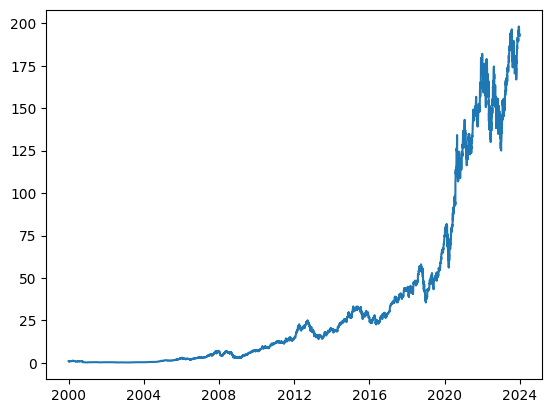

In [18]:
import yfinance as yf
import matplotlib.pyplot as plt

df = yf.download("AAPL", start='2000-01-03', end='2023-12-30')

print(df.tail())
print(df.describe())

plt.plot(df['Close'])

[*********************100%%**********************]  3 of 3 completed

Ticker          AAPL        FE        WMT
Date                                     
2000-01-03  0.846127  7.440516  14.419452
2000-01-04  0.774790  7.440516  13.879904
2000-01-05  0.786128  7.714534  13.596641
2000-01-06  0.718097  7.735610  13.745010
2000-01-07  0.752113  7.777763  14.783648
Ticker            AAPL         FE        WMT
Date                                        
2023-12-22  193.353287  35.819885  51.859924
2023-12-26  192.803986  35.928642  51.780468
2023-12-27  192.903839  35.908867  52.267120
2023-12-28  193.333298  36.175812  52.164497
2023-12-29  192.284637  36.245018  52.190979
Ticker         AAPL           FE          WMT
count   6037.000000  6037.000000  6037.000000
mean      34.509795    24.472175    21.106066
std       50.786127     8.310898    12.374883
min        0.198346     6.235910     9.366559
25%        1.837121    19.758533    11.832491
50%       12.349163    24.212017    15.025210
75%       39.221977    30.020050    25.846233
max      197.857529    

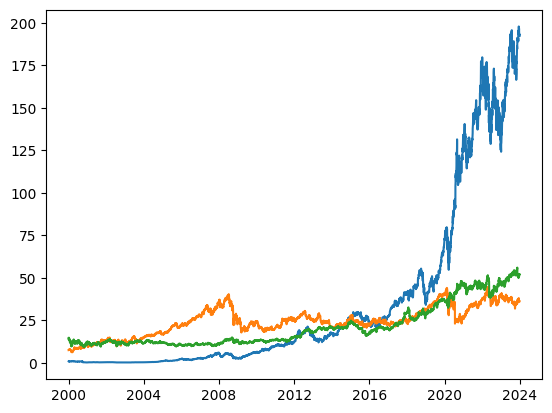

In [19]:
stocks = ['AAPL', 'FE', 'WMT']

stock_prices = yf.download(stocks, start='2000-01-03', end='2023-12-30')['Adj Close']

print(stock_prices.head())
print(stock_prices.tail())
print(stock_prices.describe())

plt.plot(stock_prices)

Ticker          AAPL        FE       WMT
Date                                    
2000-01-04  0.915690  1.000000  0.962582
2000-01-05  0.929089  1.036828  0.942937
2000-01-06  0.848688  1.039660  0.953227
2000-01-07  0.888889  1.045326  1.025257
2000-01-10  0.873255  1.048159  1.006548
Ticker          AAPL        FE       WMT
Date                                    
2000-01-04 -0.084310  0.000000 -0.037418
2000-01-05  0.014633  0.036828 -0.020408
2000-01-06 -0.086538  0.002732  0.010912
2000-01-07  0.047369  0.005449  0.075565
2000-01-10 -0.017588  0.002710 -0.018248
Ticker
AAPL    7.352463
FE      2.389604
WMT     1.949259
dtype: float64


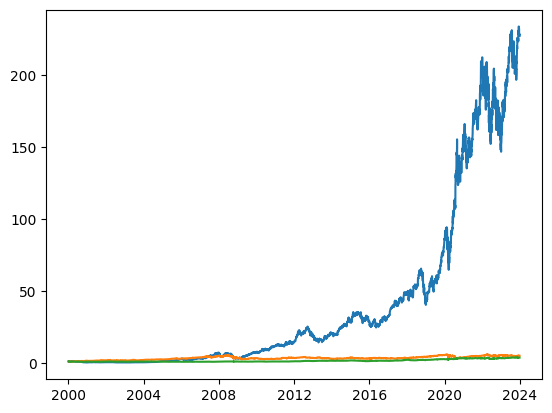

In [20]:
stock_returns = stock_prices.pct_change().dropna()
stock_returns_cumulative = (1 + stock_returns).cumprod()

print(stock_returns_cumulative.head())
print(stock_returns.head())
print(stock_returns.sum())
plt.plot(stock_returns_cumulative)



In [21]:
# Get risk free rate - T-Bills
import pandas_datareader as pdr
 
rf = pdr.DataReader('TB3MS', 'fred', start='2000-01-01', end='2023-12-30')
# Result as %, so 5% is represented as 5
print(rf.head())

# SPY as market proxy
mkt_prices = yf.download('SPY', start='2000-01-03', end='2023-12-30')['Adj Close']
print(mkt_prices.head())

[*********************100%%**********************]  1 of 1 completed

            TB3MS
DATE             
2000-01-01   5.32
2000-02-01   5.55
2000-03-01   5.69
2000-04-01   5.66
2000-05-01   5.79
Date
2000-01-03    93.591125
2000-01-04    89.931152
2000-01-05    90.092056
2000-01-06    88.644081
2000-01-07    93.792282
Name: Adj Close, dtype: float64


In [22]:
import statsmodels.api as sm

# Resample to monthly, to match T-Bill data
stock_prices_monthly = stock_prices.resample('MS').first()
mkt_prices_monthly = mkt_prices.resample('MS').first()

aapl_returns_monthly = stock_prices_monthly['AAPL'].pct_change()
mkt_returns_monthly = mkt_prices_monthly.pct_change()
# Divide the risk-free rate by 100 and then by 12 to convert it 
# from an annual percentage to a monthly decimal value.
y = (aapl_returns_monthly - rf['TB3MS']/100/12).dropna()
X = (mkt_returns_monthly - rf['TB3MS']/100/12).dropna()
# To perform the regression, first we describe the regression model by 
# defining the data used for the dependent variable on the left side of the regression, 
# y, and the independent variable(s) on the right-hand side, X.
model = sm.OLS(y,X)
results = model.fit()
# x1 in the result is the beta of the stock (AAPL) to the market (SPY)
print(results.summary())
print()

rf_last = rf['TB3MS'].iloc[-1]/100
mkt_avg = mkt_returns_monthly.mean()*12
beta = results.params['x1']

print('The current risk-free rate is', rf_last*100,'%')
# Expected market return
print('The avg annualized market return is', mkt_avg*100, '%')

exp_ret = rf_last + beta*(mkt_avg - rf_last)
print('The expected return of the stock is', exp_ret*100, '%')

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.306
Model:                            OLS   Adj. R-squared (uncentered):              0.304
Method:                 Least Squares   F-statistic:                              126.1
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.75e-24
Time:                        23:03:15   Log-Likelihood:                          262.02
No. Observations:                 287   AIC:                                     -522.0
Df Residuals:                     286   BIC:                                     -518.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
def calculate_exp_ret(stock, market, rf):
    rf_monthly = rf['TB3MS']/100/12
    y = (stock - rf_monthly).dropna()
    X = (market - rf_monthly).dropna()
    model = sm.OLS(y,X)
    results = model.fit()
    beta = results.params['x1']
    rf_last = rf['TB3MS'].iloc[-1]/100
    mkt_avg = market.mean()*12
    exp_ret = rf_last + beta*(mkt_avg - rf_last)
    return exp_ret, beta

for stock in stocks:
    stock_prices_monthly = stock_prices.resample('MS').first()
    mkt_prices_monthly = mkt_prices.resample('MS').first()
    stock_returns_monthly = stock_prices_monthly[stock].pct_change()
    mkt_returns_monthly = mkt_prices_monthly.pct_change()
    exp_ret, beta = calculate_exp_ret(stock_returns_monthly, mkt_returns_monthly, rf)
    print('Stock:', stock, '\tCAPM Exp Ret:', (exp_ret*100).round(3), '%. \tBeta:', beta.round(3))
    

Stock: AAPL 	CAPM Exp Ret: 8.973 %. 	Beta: 1.317
Stock: FE 	CAPM Exp Ret: 6.085 %. 	Beta: 0.298
Stock: WMT 	CAPM Exp Ret: 6.594 %. 	Beta: 0.478


/tmp/ipykernel_222598/1329443358.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bond_monthly = bond.resample('M').last()
/tmp/ipykernel_222598/1329443358.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  TenYr_monthly = TenYr.resample('M').last()
/tmp/ipykernel_222598/1329443358.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rf_monthly = rf.resample('M').last()/100


raw bond average returns  0.09673030238651528
excess bond average returns  0.06364354439564769


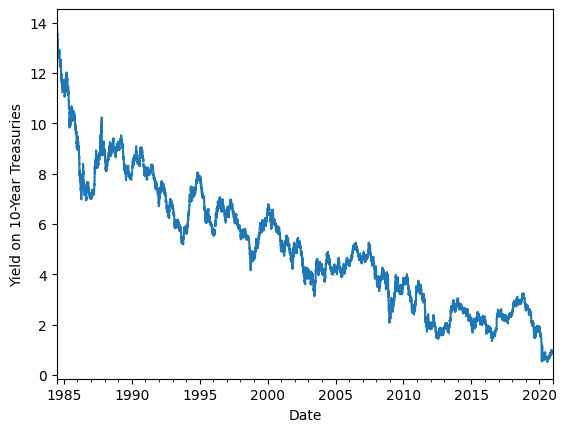

In [24]:
# Chapter 3.1.3 Adjusting Historical Returns for Changes in Valuation

start = '1984-06-29'
end = '2020-12-31'
symbol = 'BAMLCC8A015PYTRIV'
 
bond = pdr.DataReader(symbol, 'fred', start=start, end=end)
bond_monthly = bond.resample('M').last()
bond_returns_monthly = bond_monthly.pct_change()
 
TenYr = pdr.DataReader('DGS10', 'fred', start='1984-06-29', end='2020-12-31')
TenYr_monthly = TenYr.resample('M').last()
TenYr_change_monthly = TenYr_monthly.diff().dropna()/100.
TenYr_change_monthly.rename(columns={"DGS10": "Change 10Yr Yield"}, inplace=True)
 
rf = pdr.DataReader('DTB3', 'fred', start='1984-06-29', end='2020-12-31')
rf_monthly = rf.resample('M').last()/100
 
TenYr.plot(xlabel='Date', ylabel='Yield on 10-Year Treasuries', legend=False)
 
print('raw bond average returns ', bond_returns_monthly[symbol].mean()*12)
print('excess bond average returns ', (bond_returns_monthly[symbol] - 
rf_monthly['DTB3'].shift()/12).mean()*12)

In [25]:
y = (bond_returns_monthly[symbol] - rf_monthly['DTB3'].shift()/12).dropna()
X = TenYr_change_monthly
X = sm.add_constant(X)
common_dates = X.index.intersection(y.index)
X = X.loc[common_dates]
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

print('The expected return after stripping out yield changes is ',results.params[0]*12)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     364.4
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           1.72e-59
Time:                        23:03:18   Log-Likelihood:                 1123.3
No. Observations:                 438   AIC:                            -2243.
Df Residuals:                     436   BIC:                            -2234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0036      0.00

/tmp/ipykernel_222598/1936624127.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('The expected return after stripping out yield changes is ',results.params[0]*12)


In [ ]:
import pandas as pd

start = '1983-01-01'
end = '2023-01-01'
 
stock = yf.download('VFINX', start=start, end=end)
stock_annual = stock.resample('AS').first()
stock_returns_annual = stock_annual['Adj Close'].pct_change()
 
CAPE = pd.read_excel('ie_data.xls', sheet_name='Data', 
               usecols=['Date', 'CAPE'], skiprows=7)
CAPE = CAPE.dropna()
CAPE['Year'] =  CAPE['Date'].astype(int)
CAPE['Month'] = round(100*(CAPE['Date']-CAPE['Year'])).astype(int)
CAPE['Year'] =  CAPE['Year'].astype(str)
CAPE['Month'] = CAPE['Month'].astype(str)
CAPE['Date'] = CAPE['Year']+'-'+CAPE['Month']+'-'+'01'
CAPE = CAPE.set_index('Date')
CAPE.index = pd.to_datetime(CAPE.index, format='%Y-%m-%d')
CAPE.drop(columns=['Year', 'Month'], inplace=True)
CAPE = CAPE.resample('AS').first()
CAPE['CAPE_returns'] = CAPE['CAPE'].pct_change()
 
rf = pdr.DataReader('DTB3', 'fred', start=start, end=end)
rf_annual = rf.resample('AS').first()/100
 
print('raw stock average returns ',stock_returns_annual.mean())
print('excess stock average returns ', (stock_returns_annual - 
              rf_annual['DTB3'].shift()).mean())



In [37]:
print(stock_returns.std() * (252**0.5))
print(stock_returns.corr())
print(stock_returns.cov() * 252)

Ticker
AAPL    0.392659
FE      0.258756
WMT     0.235451
dtype: float64
Ticker      AAPL        FE       WMT
Ticker                              
AAPL    1.000000  0.209247  0.261399
FE      0.209247  1.000000  0.265760
WMT     0.261399  0.265760  1.000000
Ticker      AAPL        FE       WMT
Ticker                              
AAPL    0.154181  0.021260  0.024167
FE      0.021260  0.066955  0.016191
WMT     0.024167  0.016191  0.055437
